In [1]:
# Connect to your drive with the dataset folder

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Utils

## Zip file extraction

In [2]:
import os
import zipfile
from tqdm import tqdm

def extract_zip(zip_path, destination_path = "/content"):

    os.makedirs(destination_path, exist_ok=True)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        members = zip_ref.infolist()
        for member in tqdm(members, desc="Extracting", unit="file"):
            zip_ref.extract(member, path=destination_path)

    print(f"Extracted to: {destination_path}")


## Copy files from folder source to folder destination given file names

In [3]:
import os
import shutil

def copy_files(file_pairs, image_dest_dir, label_dest_dir):
    for image_file, label_file in file_pairs:
        shutil.copy(image_file, image_dest_dir)
        shutil.copy(label_file, label_dest_dir)

## Delete folder

In [4]:
import os
import shutil

def delete_folder(folder_path):
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        print(f"Folder '{folder_path}' deleted")
    else:
        print(f"Folder '{folder_path}' doesn't exist")

## Verify matching files

In [5]:
import os

def verify_matching_files(img_folder, lbl_folder):

    img_files = os.listdir(img_folder)
    lbl_files = os.listdir(lbl_folder)

    img_files=set(img_files)
    lbl_files=set(lbl_files)

    only_in_img = img_files - lbl_files
    only_in_lbl = lbl_files - img_files

    ok = True

    if only_in_img:
        ok = False
        print(f"Error: these names are only in '{img_folder}':")
        for n in sorted(only_in_img):
            print(f"{n }")

    if only_in_lbl:
        ok = False
        print(f"Error: these names are only in '{lbl_folder}':")
        for n in sorted(only_in_lbl):
            print(f"{n }")

    if ok:
        print(f"File names in '{img_folder}' and '{lbl_folder}' are the same")
    return ok

# Importing Preprocessed data from Drive

In [6]:
# Unzip preprocessed dataset from Drive to Colab
preprocessed_dataset_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning Project/preprocessed_dataset.zip'
extract_zip(preprocessed_dataset_path)

# Main folder
images_dir = '/content/imagesTr'
labels_dir = '/content/labelsTr'

Extracting: 100%|██████████| 842/842 [01:35<00:00,  8.80file/s] 

Extracted to: /content


# Train Validation Test split

### Stratified function

In [7]:
import os
import nibabel as nib
import pandas as pd
from sklearn.model_selection import train_test_split

def stratified_split_ids(images_folder, labels_folder,
                         train_ratio=0.8, validation_ratio=0.1, test_ratio=0.1,
                         seed=1748):

    # Gather label stats for stratification
    stats = []
    for fname in sorted(os.listdir(labels_folder)):
        if not fname.endswith('.nii.gz'):
            continue
        pid = fname.replace('.nii.gz', '')
        label_path = os.path.join(labels_folder, fname)
        label = nib.load(label_path).get_fdata()
        volume = np.sum(label > 0)
        class_counts = np.bincount(label.astype(np.int32).flatten(), minlength=4)

        stats.append({
            "filename": pid,
            "volume": volume,
            "class0": class_counts[0],
            "class1": class_counts[1],
            "class2": class_counts[2],
            "class3": class_counts[3]
        })

    df = pd.DataFrame(stats)
    # Allow dropping duplicates if bins are not unique
    df['volume_bin'] = pd.qcut(df['volume'], q=4, labels=False, duplicates='drop')

    def make_strat_label(row):
        c1 = int(row['class1'] > 0)
        c2 = int(row['class2'] > 0)
        c3 = int(row['class3'] > 0)
        # Include volume_bin in the stratification label
        return f"{row['volume_bin']}_{c1}{c2}{c3}"

    df['strat_label'] = df.apply(make_strat_label, axis=1)

    # Identify rare groups with less than 2 samples
    counts = df['strat_label'].value_counts()
    rare_groups = counts[counts < 2].index.tolist()

    # Print rare group samples before reassignment
    print("Samples in rare stratification groups (less than 2 samples):")
    for rare_group in rare_groups:
        rare_samples = df[df['strat_label'] == rare_group]['filename'].tolist()
        print(f"Group '{rare_group}': {rare_samples}")

    # Merge rare groups into 'rare' to avoid stratify errors initially
    df['strat_label'] = df['strat_label'].apply(lambda x: 'rare' if x in rare_groups else x)

    # Recalculate counts after merging rare groups
    updated_counts = df['strat_label'].value_counts()
    print("Stratification group counts after initial merging:")
    print(updated_counts)

    # Handle single-member groups after merging
    single_member_groups = updated_counts[updated_counts < 2].index.tolist()
    if single_member_groups:
        print(f"Found single-member stratification groups after merging: {single_member_groups}. Reassigning these samples.")
        # Find the largest group (excluding single-member ones)
        largest_group = updated_counts[~updated_counts.index.isin(single_member_groups)].idxmax()
        print(f"Largest group is: {largest_group}. Reassigning single samples to this group.")

        for group_label in single_member_groups:
            single_sample_id = df[df['strat_label'] == group_label]['filename'].iloc[0]
            df.loc[df['filename'] == single_sample_id, 'strat_label'] = largest_group
            print(f"Reassigned sample {single_sample_id} from group '{group_label}' to group '{largest_group}'.")

        # Final counts after reassignment
        final_counts = df['strat_label'].value_counts()
        print("Stratification group counts after reassignment:")
        print(final_counts)

    ids = df['filename'].values
    strat_labels = df['strat_label'].values

    # Split off test set first
    trainval_ids, test_ids, trainval_strat, test_strat = train_test_split(
        ids, strat_labels, test_size=test_ratio, random_state=seed, stratify=strat_labels)

    # Adjust validation ratio relative to train+val set size
    val_ratio_adjusted = validation_ratio / (train_ratio + validation_ratio)

    train_ids, val_ids, train_strat, val_strat = train_test_split(
        trainval_ids, trainval_strat, test_size=val_ratio_adjusted, random_state=seed, stratify=trainval_strat)

    print(f"Total IDs count: {len(ids)}")
    print(f"Train IDs count: {len(train_ids)}")
    print(f"Validation IDs count: {len(val_ids)}")
    print(f"Test IDs count: {len(test_ids)}")

    return list(train_ids), list(val_ids), list(test_ids)

### Split

In [8]:
import os
import shutil
import random
import numpy as np

# new folders creation
image_train_dir = '/content/imageTrain'
label_train_dir = '/content/labelTrain'
image_validation_dir = '/content/imageValidation'
label_validation_dir = '/content/labelValidation'
image_test_dir = '/content/imageTest'
label_test_dir = '/content/labelTest'
for d in [image_train_dir, label_train_dir, image_validation_dir, label_validation_dir, image_test_dir, label_test_dir]:
    os.makedirs(d, exist_ok=True)

train_ids, validation_ids, test_ids = stratified_split_ids(images_dir, labels_dir)

# create list of (image_path, label_path)
train_files = [(os.path.join(images_dir, f"{id}.nii.gz"), os.path.join(labels_dir, f"{id}.nii.gz")) for id in train_ids]
validation_files = [(os.path.join(images_dir, f"{id}.nii.gz"), os.path.join(labels_dir, f"{id}.nii.gz")) for id in validation_ids]
test_files = [(os.path.join(images_dir, f"{id}.nii.gz"), os.path.join(labels_dir, f"{id}.nii.gz")) for id in test_ids]

# copy
copy_files(train_files, image_train_dir, label_train_dir)
copy_files(validation_files, image_validation_dir, label_validation_dir)
copy_files(test_files, image_test_dir, label_test_dir)

# delete
delete_folder(images_dir)
delete_folder(labels_dir)

# check matching files
verify_matching_files(image_train_dir, label_train_dir)
verify_matching_files(image_validation_dir, label_validation_dir)
verify_matching_files(image_test_dir, label_test_dir)

Samples in rare stratification groups (less than 2 samples):
Group '0_010': ['BRATS_026']
Stratification group counts after initial merging:
strat_label
2_111    105
3_111    105
1_111    105
0_111    104
rare       1
Name: count, dtype: int64
Found single-member stratification groups after merging: ['rare']. Reassigning these samples.
Largest group is: 2_111. Reassigning single samples to this group.
Reassigned sample BRATS_026 from group 'rare' to group '2_111'.
Stratification group counts after reassignment:
strat_label
2_111    106
3_111    105
1_111    105
0_111    104
Name: count, dtype: int64
Total IDs count: 420
Train IDs count: 336
Validation IDs count: 42
Test IDs count: 42
Folder '/content/imagesTr' deleted
Folder '/content/labelsTr' deleted
File names in '/content/imageTrain' and '/content/labelTrain' are the same
File names in '/content/imageValidation' and '/content/labelValidation' are the same
File names in '/content/imageTest' and '/content/labelTest' are the same


True

### check

(160, 160, 128, 4)
(160, 160, 128)
0.2261580377817154
0.0


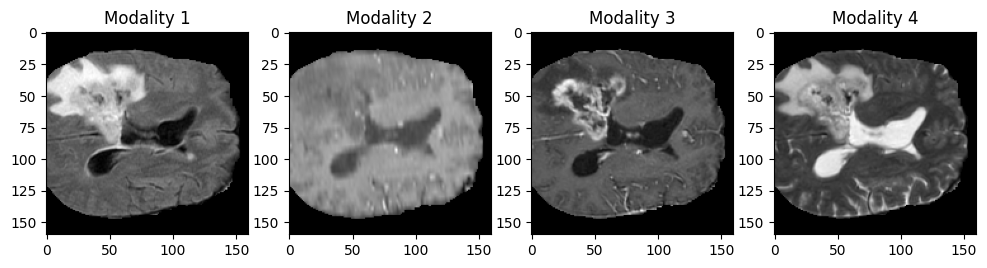

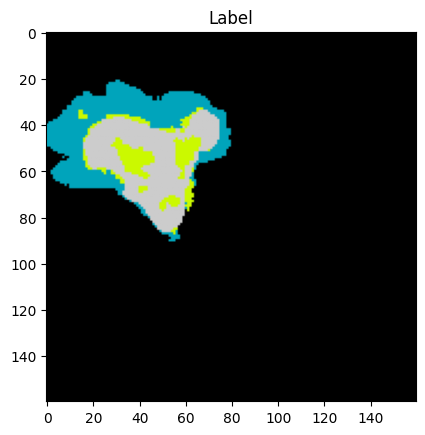

In [9]:
# check
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

nii_file = nib.load("/content/imageTrain/BRATS_142.nii.gz")
img_norm = nii_file.get_fdata()
nii_file = nib.load("/content/labelTrain/BRATS_142.nii.gz")
lbl = nii_file.get_fdata()

print(img_norm.shape)
print(lbl.shape)
print(img_norm[80][80][60][2])
print(lbl[100][120][64])

def show_4_mri_with_labels(volume, label):
  # Create figure for modalities
  plt.figure(figsize=(12, 4))

  # Loop through the 4 modalities
  for i in range(4):
      # Create subplot
      plt.subplot(1, 4, i+1)
      # Display middle slice of current modality
      plt.imshow(volume[..., volume.shape[2]//2, i], cmap='gray')
      """
      ...: all rows, all columns
      volume.shape[2] is the number of slices (DEPTH)
      volume.shape[2] // 2 takes the middle slice index
      i is the modality index (from 0 to 3)
      It's like saying: “Give me the 2D image for the center of the brain, for modality i.”
      The result is a 2D image of shape (H, W).
      """
      # Set modality title
      plt.title(f'Modality {i+1}')

  # Show modality plots
  plt.show()

  # Display middle slice of label
  plt.imshow(label[..., label.shape[2]//2], cmap='nipy_spectral')
  # Set label title
  plt.title('Label')

  # Show label plot
  plt.show()

show_4_mri_with_labels(img_norm, lbl)

# Custom data generator

### data augmentation 'on fly'

In [10]:
import nibabel as nib
import numpy as np
import os
from scipy import ndimage

def random_augment_3d(image, label):
    """
    image: numpy array (H, W, D, C)
    label: numpy array (H, W, D, C)
    """
    # symmetric to x-axis
    if np.random.rand() > 0.5:
        image = np.flip(image, axis=0)
        label = np.flip(label, axis=0)

    # symmetric to y-axis
    if np.random.rand() > 0.5:
        image = np.flip(image, axis=1)
        label = np.flip(label, axis=1)

    # symmetric to z-axis
    if np.random.rand() > 0.5:
        image = np.flip(image, axis=2)
        label = np.flip(label, axis=2)

    # light gaussian noise ONLY on background
    if np.random.rand() > 0.5:
        # background mask from the one-hot encoded label
        background_mask = label[..., 0] == 1  # shape (H, W, D)

        # expand to match image channels
        background_mask = np.expand_dims(background_mask, axis=-1)  # shape (H, W, D, 1)
        background_mask = np.repeat(background_mask, image.shape[-1], axis=-1)  # shape (H, W, D, C)

        # apply gaussian noise only to background
        noise = np.random.normal(0, 0.01, size=image.shape)
        image = image + noise * background_mask

    return image, label

### One hot enconding labels

In [11]:
# labels must be one hot encoded

import tensorflow as tf

def one_hot_encode_label_tf(label, num_classes=4):
    label = tf.convert_to_tensor(label, dtype=tf.int32)
    one_hot = tf.one_hot(label, depth=num_classes)
    return one_hot.numpy()

### Batch generator

In [12]:
# function to load a group of .nii.gz files from a folder and return them as a NumPy vector

import os
import numpy as np
import nibabel as nib

def load_list(file_dir, file_list):
    # file_list is a list of filenames like ["BRATS_001.nii.gz", ...]

    vector = []

    for filename in file_list:
        path = os.path.join(file_dir, filename)
        current = nib.load(path).get_fdata()

        if current.ndim == 3: # if label
          current = one_hot_encode_label_tf(current)

        vector.append(current)

    return np.array(vector)

In [13]:
# function to generate the Batch: a vector where each element is a tuple: (image, label)

def batchLoader(img_dir, img_list, label_dir, label_list, batch_size, augment=True):

    L = len(img_list)

    # Keras requires batches to be provided one at the time
    while True:

        indices = np.random.permutation(L)
        img_list = np.array(img_list)[indices]
        label_list = np.array(label_list)[indices]

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            X = load_list(img_dir, img_list[batch_start:limit])
            Y = load_list(label_dir, label_list[batch_start:limit])

            # data augmentation
            if augment:
                for i in range(len(X)):
                    X[i], Y[i] = random_augment_3d(X[i], Y[i])

            yield (X,Y)
            # similar to 'return' but it doesn't end the function, it just suspends it.
            # It builds a tuple with two numpy arrays with batch_size samples

            batch_start += batch_size
            batch_end += batch_size

# 3D U-Net

### Instance normalization function

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class InstanceNormalization(Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        self.gamma = self.add_weight(shape=(input_shape[-1],),
                                     initializer="ones",
                                     trainable=True)
        self.beta = self.add_weight(shape=(input_shape[-1],),
                                    initializer="zeros",
                                    trainable=True)

    def call(self, inputs):
        mean, variance = tf.nn.moments(inputs, axes=[1, 2, 3], keepdims=True)
        normalized = (inputs - mean) / tf.sqrt(variance + self.epsilon)
        return self.gamma * normalized + self.beta

    def get_config(self):
        config = super().get_config()
        config.update({"epsilon": self.epsilon})
        return config

### 3D U-net

In [15]:
from tensorflow.keras.layers import Input, Conv3D, Conv3DTranspose, MaxPooling3D, Dropout, concatenate, Activation
from tensorflow.keras.models import Model

kernel_initializer = 'he_uniform'

def TriDimensional_Unet_Model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))

    # Contracting path
    c1 = Conv3D(16, (3, 3, 3), activation=None, kernel_initializer=kernel_initializer, padding='same')(inputs)
    c1 = InstanceNormalization()(c1)
    c1 = Activation('relu')(c1)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation=None, kernel_initializer=kernel_initializer, padding='same')(c1)
    c1 = InstanceNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(32, (3, 3, 3), activation=None, kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = InstanceNormalization()(c2)
    c2 = Activation('relu')(c2)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation=None, kernel_initializer=kernel_initializer, padding='same')(c2)
    c2 = InstanceNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(64, (3, 3, 3), activation=None, kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = InstanceNormalization()(c3)
    c3 = Activation('relu')(c3)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation=None, kernel_initializer=kernel_initializer, padding='same')(c3)
    c3 = InstanceNormalization()(c3)
    c3 = Activation('relu')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = Conv3D(128, (3, 3, 3), activation=None, kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = InstanceNormalization()(c4)
    c4 = Activation('relu')(c4)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation=None, kernel_initializer=kernel_initializer, padding='same')(c4)
    c4 = InstanceNormalization()(c4)
    c4 = Activation('relu')(c4)
    p4 = MaxPooling3D((2, 2, 2))(c4)

    c5 = Conv3D(256, (3, 3, 3), activation=None, kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = InstanceNormalization()(c5)
    c5 = Activation('relu')(c5)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation=None, kernel_initializer=kernel_initializer, padding='same')(c5)
    c5 = InstanceNormalization()(c5)
    c5 = Activation('relu')(c5)

    # Expansive path
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same', activation=None)(c5)
    u6 = InstanceNormalization()(u6)
    u6 = Activation('relu')(u6)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation=None, kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = InstanceNormalization()(c6)
    c6 = Activation('relu')(c6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation=None, kernel_initializer=kernel_initializer, padding='same')(c6)
    c6 = InstanceNormalization()(c6)
    c6 = Activation('relu')(c6)

    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same', activation=None)(c6)
    u7 = InstanceNormalization()(u7)
    u7 = Activation('relu')(u7)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation=None, kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = InstanceNormalization()(c7)
    c7 = Activation('relu')(c7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation=None, kernel_initializer=kernel_initializer, padding='same')(c7)
    c7 = InstanceNormalization()(c7)
    c7 = Activation('relu')(c7)

    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same', activation=None)(c7)
    u8 = InstanceNormalization()(u8)
    u8 = Activation('relu')(u8)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation=None, kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = InstanceNormalization()(c8)
    c8 = Activation('relu')(c8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation=None, kernel_initializer=kernel_initializer, padding='same')(c8)
    c8 = InstanceNormalization()(c8)
    c8 = Activation('relu')(c8)

    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same', activation=None)(c8)
    u9 = InstanceNormalization()(u9)
    u9 = Activation('relu')(u9)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation=None, kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = InstanceNormalization()(c9)
    c9 = Activation('relu')(c9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation=None, kernel_initializer=kernel_initializer, padding='same')(c9)
    # InstanceNormalization not needed with softmax qui per non interferire con il softmax finale

    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9) # 4 channels where, per each voxel, the sum of the four voxels is 1

    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()

    return model

# Training

In [16]:
# define paths and data generator

import os
import numpy as np
import tensorflow as tf
import keras
import random

train_img_dir = "/content/imageTrain/"
train_lbl_dir = "/content/labelTrain/"
train_img_list = sorted(os.listdir(train_img_dir))
train_lbl_list = sorted(os.listdir(train_lbl_dir))

val_img_dir = "/content/imageValidation/"
val_lbl_dir = "/content/labelValidation/"
val_img_list = sorted(os.listdir(val_img_dir))
val_lbl_list = sorted(os.listdir(val_lbl_dir))

np.random.seed(1312)

batch_size = 2
train_generator = batchLoader(train_img_dir, train_img_list,
                                train_lbl_dir, train_lbl_list, batch_size)
validation_generator = batchLoader(val_img_dir, val_img_list,
                                val_lbl_dir, val_lbl_list, batch_size)

### check on my generator

BRATS_140.nii.gz
BRATS_140.nii.gz
Image shape:  (2, 160, 160, 128, 4)
Label shape:  (2, 160, 160, 128, 4)


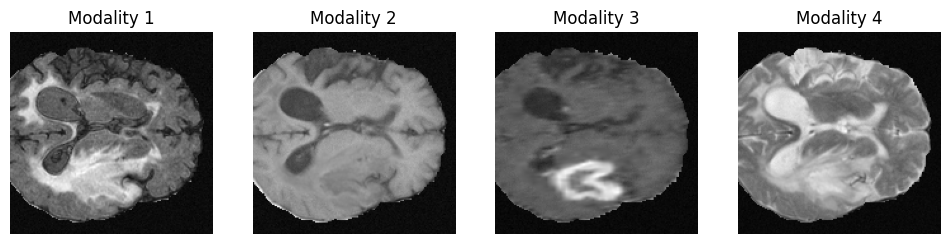

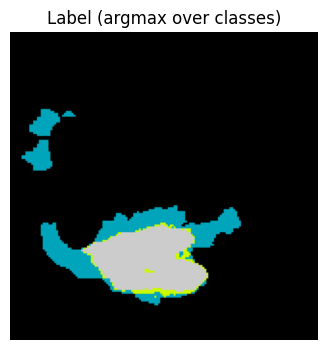

In [17]:
print(train_img_list[100])
print(train_lbl_list[100])

np.random.seed(100)

my_datagen = batchLoader(train_img_dir, train_img_list, train_lbl_dir, train_lbl_list, batch_size)
batch_images, batch_labels = next(my_datagen)
print("Image shape: ", batch_images.shape)
print("Label shape: ", batch_labels.shape)


def show_4_mri_with_labels_hot_encoded(volume, label):
    # show the 4 brain resonance modalities
    plt.figure(figsize=(12, 4))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.imshow(volume[..., volume.shape[2] // 2, i], cmap='gray')
        plt.title(f'Modality {i + 1}')
        plt.axis('off')
    plt.show()

    # extract the central slice according to depth of the label
    middle_slice = label[..., label.shape[2] // 2, :]  # shape (H, W, num_classes)
    #arg_max on channels for each pixel
    label_slice = np.argmax(middle_slice, axis=-1)     # shape (H, W)

    # show the label
    plt.figure(figsize=(4, 4))
    plt.imshow(label_slice, cmap='nipy_spectral')
    plt.title('Label (argmax over classes)')
    plt.axis('off')
    plt.show()
show_4_mri_with_labels_hot_encoded(batch_images[0], batch_labels[0])

# Loss

### Categorical Cross Entropy Loss

In [18]:
import tensorflow as tf
from tensorflow.keras.losses import CategoricalCrossentropy

cce_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
# false, since I have a final softmax

In [19]:
# check on Categorical Cross Entropy loss
img_norm = nib.load("/content/imageTrain/BRATS_015.nii.gz").get_fdata()
lbl = nib.load("/content/labelTrain/BRATS_015.nii.gz").get_fdata()
lbl_onehot = one_hot_encode_label_tf(lbl)

print(cce_loss(lbl_onehot, lbl_onehot))

tf.Tensor(1.192093e-07, shape=(), dtype=float32)


### Dice Loss

In [20]:
import tensorflow as tf

def dice_loss_3d(y_true, y_pred, smooth=1e-6):
    """
    y_true: tensor (batch, h, w, d, classes): one-hot encoded
    y_pred: tensor (batch, h, w, d, classes): after softmax
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1,2,3])

    # Dice per class, per each element of the batch
    dice_per_class = (2. * intersection + smooth) / (union + smooth)

    # average on classes, then on batch
    dice_loss = 1 - tf.reduce_mean(dice_per_class, axis=-1)  # on classes
    return tf.reduce_mean(dice_loss)  # on batch

In [21]:
# check on Dice loss
img_norm = nib.load("/content/imageTrain/BRATS_015.nii.gz").get_fdata()
lbl = nib.load("/content/labelTrain/BRATS_015.nii.gz").get_fdata()
lbl_onehot = one_hot_encode_label_tf(lbl)

print(dice_loss_3d(lbl_onehot, lbl_onehot))

tf.Tensor(0.0, shape=(), dtype=float32)


##Categorical Cross Entropy Loss and Dice Loss

In [22]:
def combined_cce_dice_loss(y_true, y_pred, alpha=0.5):
    cce = cce_loss(y_true, y_pred)
    dice = dice_loss_3d(y_true, y_pred)
    return alpha * cce + (1-alpha) * dice

## Compile

In [23]:
# define and compile the model

seed=1312
tf.random.set_seed(seed)

metrics = [keras.metrics.OneHotIoU(num_classes=4, target_class_ids=[0, 1, 2, 3])]
LR = 0.0001
optim = keras.optimizers.Adam(LR)

steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

model = TriDimensional_Unet_Model(IMG_HEIGHT=160, IMG_WIDTH=160, IMG_DEPTH=128, IMG_CHANNELS=4, num_classes=4)
model.compile(optimizer=optim, loss=combined_cce_dice_loss, metrics=metrics)

print(model.input_shape)
print(model.output_shape)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 128, 4)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 160, 160,  │      1,744 │ input_layer[0][0] │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 160, 160,  │         32 │ conv3d[0][0]      │
│ (InstanceNormaliza… │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 160, 160,  │          0 │ instance_normali… │
│ (Activation)        │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 160, 160,  │          0 │ activation[0][0]  │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 160, 160,  │      6,928 │ dropout[0][0]     │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 160, 160,  │         32 │ conv3d_1[0][0]    │
│ (InstanceNormaliza… │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 160, 160,  │          0 │ instance_normali… │
│ (Activation)        │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 80, 80,    │          0 │ activation_1[0][… │
│ (MaxPooling3D)      │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 80, 80,    │     13,856 │ max_pooling3d[0]… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 80, 80,    │         64 │ conv3d_2[0][0]    │
│ (InstanceNormaliza… │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 80, 80,    │          0 │ instance_normali… │
│ (Activation)        │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 80, 80,    │          0 │ activation_2[0][… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 80, 80,    │     27,680 │ dropout_1[0][0]   │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 80, 80,    │         64 │ conv3d_3[0][0]    │
│ (InstanceNormaliza… │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 80, 80,    │          0 │ instance_normali… │
│ (Activation)        │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 40, 40,    │          0 │ activation_3[0][

 Total params: 5,649,652 (21.55 MB)

 Trainable params: 5,649,652 (21.55 MB)

 Non-trainable params: 0 (0.00 B)

(None, 160, 160, 128, 4)
(None, 160, 160, 128, 4)


### callback to save results

In [24]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Colab Notebooks/Deep Learning Project/checkpoints/Cross Entropy & Dice loss v4/epoch_{epoch:02d}.keras',
    save_freq='epoch',
    save_weights_only=False,
    save_best_only=False,
    verbose=1
)

### CSV logger to save metrics and losses

In [25]:
from tensorflow.keras.callbacks import CSVLogger

csv_logger = CSVLogger('/content/drive/MyDrive/Colab Notebooks/Deep Learning Project/checkpoints/Cross Entropy & Dice loss v4/losses_metrics.csv', append=True)

# Fit

In [ ]:
history=model.fit(train_generator,
                  steps_per_epoch=steps_per_epoch,
                  epochs=100,
                  verbose=1,
                  validation_data=validation_generator,
                  validation_steps=val_steps_per_epoch,
                  callbacks=[checkpoint_callback, csv_logger]
                  )

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 160, 160, 128, 4))
  warnings.warn(msg)


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.7916 - one_hot_io_u: 0.2092

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 160, 160, 128, 4))
  warnings.warn(msg)



Epoch 1: saving model to /content/drive/MyDrive/Colab Notebooks/Deep Learning Project/checkpoints/Cross Entropy & Dice loss v4/epoch_01.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 731s 4s/step - loss: 0.7899 - one_hot_io_u: 0.2097 - val_loss: 0.2659 - val_one_hot_io_u: 0.5417
Epoch 2/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.2403 - one_hot_io_u: 0.5668
Epoch 2: saving model to /content/drive/MyDrive/Colab Notebooks/Deep Learning Project/checkpoints/Cross Entropy & Dice loss v4/epoch_02.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 677s 4s/step - loss: 0.2402 - one_hot_io_u: 0.5669 - val_loss: 0.1925 - val_one_hot_io_u: 0.6415
Epoch 3/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1937 - one_hot_io_u: 0.6263
Epoch 3: saving model to /content/drive/MyDrive/Colab Notebooks/Deep Learning Project/checkpoints/Cross Entropy & Dice loss v4/epoch_03.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 625s 4s/step - loss: 0.1936 - one_hot_io_u: 0.6263 - val_loss: 0.1873 - val_one_hot_io_u: 0.6351
Epoch 4/100
168

## Restart the training after interruption due to limited gpu (8-17)

In [ ]:
from tensorflow import keras

# load the model from epoch 8
model = keras.models.load_model(
    '/content/drive/MyDrive/Colab Notebooks/Deep Learning Project/checkpoints/Cross Entropy & Dice loss v4/epoch_08.keras',
    custom_objects={
        'InstanceNormalization': InstanceNormalization,
        'combined_cce_dice_loss': combined_cce_dice_loss
    },
    compile=True
)

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=100,
                    initial_epoch=8,
                    validation_data=validation_generator,
                    validation_steps=val_steps_per_epoch,
                    callbacks=[checkpoint_callback, csv_logger]
)

Epoch 9/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1571 - one_hot_io_u: 0.6838
Epoch 9: saving model to /content/drive/MyDrive/Colab Notebooks/Deep Learning Project/checkpoints/Cross Entropy & Dice loss v4/epoch_09.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 683s 3s/step - loss: 0.1571 - one_hot_io_u: 0.6838 - val_loss: 0.1621 - val_one_hot_io_u: 0.6825
Epoch 10/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1453 - one_hot_io_u: 0.7036
Epoch 10: saving model to /content/drive/MyDrive/Colab Notebooks/Deep Learning Project/checkpoints/Cross Entropy & Dice loss v4/epoch_10.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 579s 3s/step - loss: 0.1453 - one_hot_io_u: 0.7036 - val_loss: 0.1543 - val_one_hot_io_u: 0.6941
Epoch 11/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1503 - one_hot_io_u: 0.6939
Epoch 11: saving model to /content/drive/MyDrive/Colab Notebooks/Deep Learning Project/checkpoints/Cross Entropy & Dice loss v4/epoch_11.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 579s 3s/step - loss

## Restart the training after interruption due to limited gpu (17-36)

In [ ]:
from tensorflow import keras

# load the model from epoch 17
model = keras.models.load_model(
    '/content/drive/MyDrive/Colab Notebooks/Deep Learning Project/checkpoints/Cross Entropy & Dice loss v4/epoch_17.keras',
    custom_objects={
        'InstanceNormalization': InstanceNormalization,
        'combined_cce_dice_loss': combined_cce_dice_loss
    },
    compile=True
)

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=100,
                    initial_epoch=17,
                    validation_data=validation_generator,
                    validation_steps=val_steps_per_epoch,
                    callbacks=[checkpoint_callback, csv_logger]
)

Epoch 18/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1399 - one_hot_io_u: 0.7116
Epoch 18: saving model to /content/drive/MyDrive/Colab Notebooks/Deep Learning Project/checkpoints/Cross Entropy & Dice loss v4/epoch_18.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 717s 4s/step - loss: 0.1399 - one_hot_io_u: 0.7117 - val_loss: 0.1485 - val_one_hot_io_u: 0.7111
Epoch 19/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1312 - one_hot_io_u: 0.7275
Epoch 19: saving model to /content/drive/MyDrive/Colab Notebooks/Deep Learning Project/checkpoints/Cross Entropy & Dice loss v4/epoch_19.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 582s 3s/step - loss: 0.1312 - one_hot_io_u: 0.7274 - val_loss: 0.1437 - val_one_hot_io_u: 0.7110
Epoch 20/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1367 - one_hot_io_u: 0.7151
Epoch 20: saving model to /content/drive/MyDrive/Colab Notebooks/Deep Learning Project/checkpoints/Cross Entropy & Dice loss v4/epoch_20.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 624s 4s/step - lo

# Evaluation

## Training and Validation performance

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning Project/checkpoints/Cross Entropy & Dice loss v4/losses_metrics.csv'
df = pd.read_csv(file_path, sep=',')

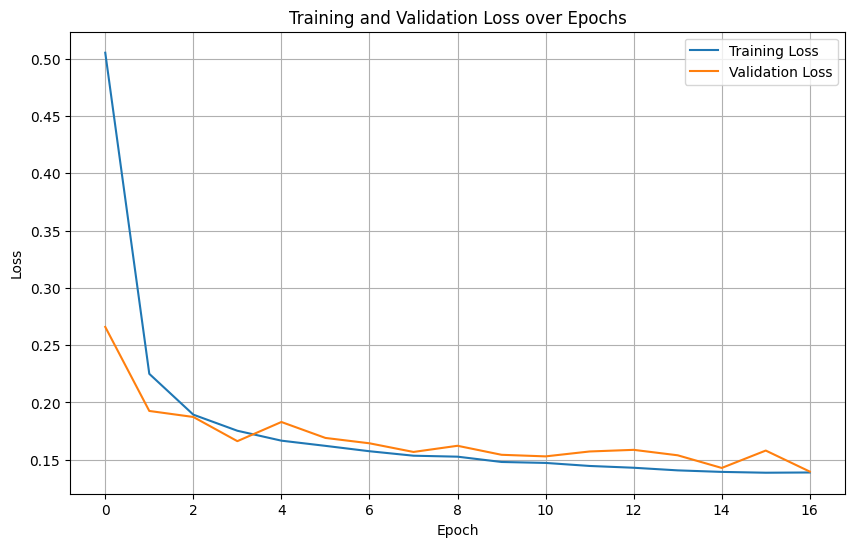

In [27]:
plt.figure(figsize=(10,6))
plt.plot(df['epoch'], df['loss'], label='Training Loss')
plt.plot(df['epoch'], df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

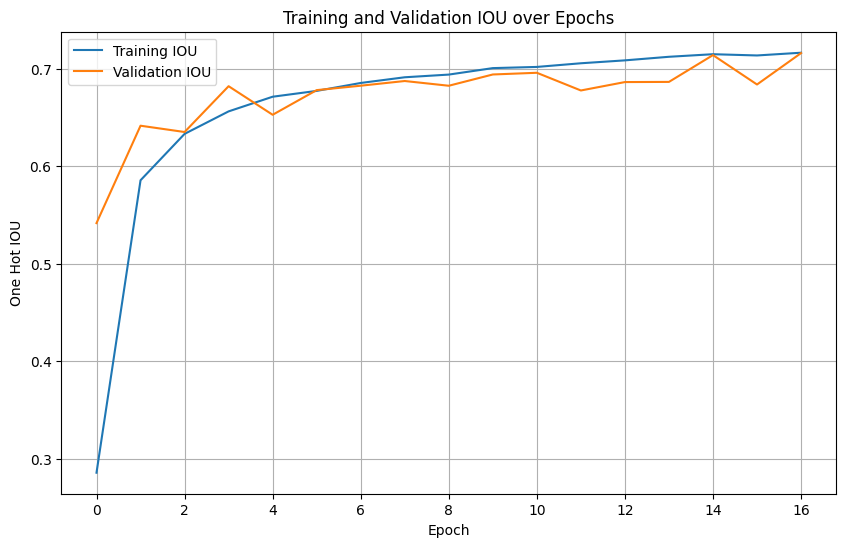

In [28]:
plt.figure(figsize=(10,6))
plt.plot(df['epoch'], df['one_hot_io_u'], label='Training IOU')
plt.plot(df['epoch'], df['val_one_hot_io_u'], label='Validation IOU')
plt.xlabel('Epoch')
plt.ylabel('One Hot IOU')
plt.title('Training and Validation IOU over Epochs')
plt.legend()
plt.grid(True)
plt.show()

## Test performance

In [29]:
# test data generator

test_img_dir = "/content/imageTest/"
test_lbl_dir = "/content/labelTest/"
test_img_list = sorted(os.listdir(test_img_dir))
test_lbl_list = sorted(os.listdir(test_lbl_dir))

np.random.seed(1312)

batch_size = 2

test_generator = batchLoader(test_img_dir, test_img_list,
                             test_lbl_dir, test_lbl_list,
                             batch_size)

In [30]:
# evaluate the model

from tensorflow import keras

model = keras.models.load_model(
    '/content/drive/MyDrive/Colab Notebooks/Deep Learning Project/checkpoints/Cross Entropy & Dice loss v4/epoch_36.keras',
    custom_objects={
        'InstanceNormalization': InstanceNormalization,
        'combined_cce_dice_loss': combined_cce_dice_loss
    },
    compile=True
)

steps_per_epoch_test = int(np.ceil(len(test_img_list) / batch_size))
print(f"Steps in test set: {steps_per_epoch_test}")

test_results = model.evaluate(test_generator, steps=steps_per_epoch_test, verbose=1) # it provides the average values of loss and IOU on test data in about xx minutes

Steps in test set: 21
21/21 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - loss: 0.1414 - one_hot_io_u: 0.7126


In [34]:
# saving results
import json
import os

results_dict = {name: float(value) for name, value in zip(model.metrics_names, test_results)}

results_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning Project/checkpoints/Cross Entropy & Dice loss v4/losses_metrics_test.json'
os.makedirs(os.path.dirname(results_path), exist_ok=True)

with open(results_path, 'w') as f:
    json.dump(results_dict, f, indent=4)

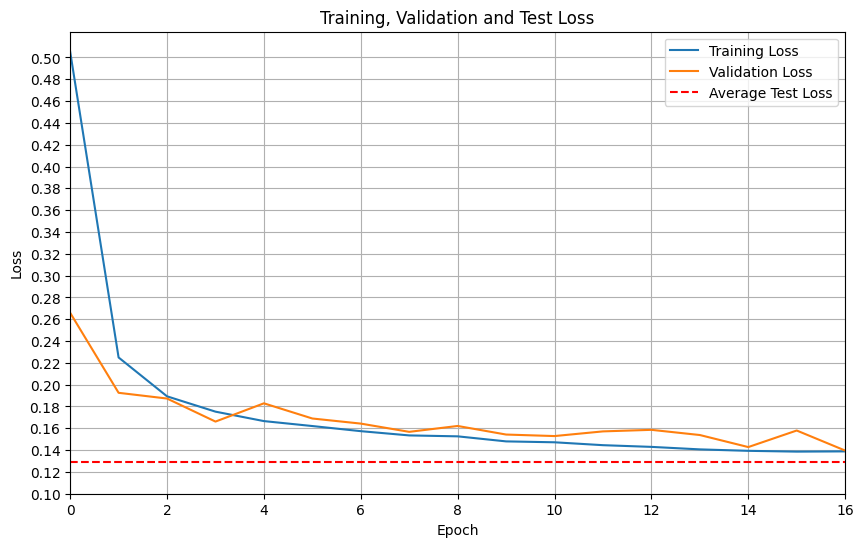

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import json

# load metrics from Json
results_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning Project/checkpoints/Cross Entropy & Dice loss v4/losses_metrics_test.json'
with open(results_path, 'r') as f:
    test_results = json.load(f)

# get values
test_loss = test_results['loss']
test_iou = test_results['compile_metrics']

# plot loss (training, val, test)
plt.figure(figsize=(10,6))
plt.plot(df['epoch'], df['loss'], label='Training Loss')
plt.plot(df['epoch'], df['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='red', linestyle='--', label='Average Test Loss')
plt.xlim(0, 16)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training, Validation and Test Loss')
plt.legend()
plt.grid(True)
plt.yticks(np.arange(0.10, 0.52, 0.02))
plt.show()

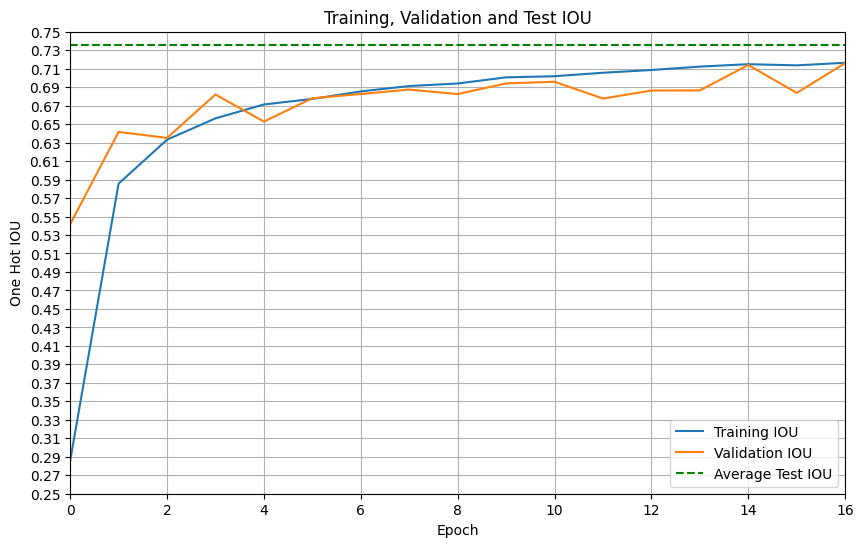

In [49]:
# plot IOU (training, val, test)
plt.figure(figsize=(10,6))
plt.plot(df['epoch'], df['one_hot_io_u'], label='Training IOU')
plt.plot(df['epoch'], df['val_one_hot_io_u'], label='Validation IOU')
plt.axhline(y=test_iou, color='green', linestyle='--', label='Average Test IOU')
plt.xlim(0, 16)
plt.xlabel('Epoch')
plt.ylabel('One Hot IOU')
plt.title('Training, Validation and Test IOU')
plt.legend()
plt.grid(True)
plt.yticks(np.arange(0.25, 0.77, 0.02))
plt.show()

### Precision & Recall on test data

In [40]:
import numpy as np
from tensorflow import keras
from sklearn.metrics import precision_score, recall_score, f1_score
import os

# load model
model = keras.models.load_model(
    '/content/drive/MyDrive/Colab Notebooks/Deep Learning Project/checkpoints/Cross Entropy & Dice loss v4/epoch_36.keras',
    custom_objects={
        'InstanceNormalization': InstanceNormalization,
        'combined_cce_dice_loss': combined_cce_dice_loss
    },
    compile=False
)

# needed batches to cover all test set
num_batches = int(np.ceil(len(test_img_list) / batch_size))

# collect ground truth and predictions
y_true_all = []
y_pred_all = []

for i in range(num_batches):
    batch_x, batch_y = next(test_generator)

    batch_pred_probs = model.predict(batch_x)
    batch_pred_classes = np.argmax(batch_pred_probs, axis=-1) # shape (batch_size, h, w, d), where each voxel has the value of the truth class [0,1,2,3]
    batch_true_classes = np.argmax(batch_y, axis=-1) # shape (batch_size, h, w, d), where each voxel has the value of the truth class [0,1,2,3]

    y_true_all.append(batch_true_classes)
    y_pred_all.append(batch_pred_classes)

# flatten
y_true_flat = np.concatenate([y.flatten() for y in y_true_all])
y_pred_flat = np.concatenate([y.flatten() for y in y_pred_all])

# metrics
precision_macro = precision_score(y_true_flat, y_pred_flat, average='macro', zero_division=0)
recall_macro = recall_score(y_true_flat, y_pred_flat, average='macro', zero_division=0)
f1_macro = f1_score(y_true_flat, y_pred_flat, average='macro', zero_division=0)

precision_per_class = precision_score(y_true_flat, y_pred_flat, average=None, zero_division=0)
recall_per_class = recall_score(y_true_flat, y_pred_flat, average=None, zero_division=0)
f1_per_class = f1_score(y_true_flat, y_pred_flat, average=None, zero_division=0)

# print
print(f'Precision (macro): {precision_macro:.4f}')
print(f'Recall (macro): {recall_macro:.4f}')
print(f'F1-score (macro):  {f1_macro:.4f}')

for i, (p, r, f1) in enumerate(zip(precision_per_class, recall_per_class, f1_per_class)):
    print(f'Class {i}: Precision = {p:.4f}, Recall = {r:.4f}, F1 = {f1:.4f}')

# save
metrics_dict = {
    "macro": {
        "precision": float(precision_macro),
        "recall": float(recall_macro),
        "f1": float(f1_macro)
    },
    "per_class": {
        f"class_{i}": {
            "precision": float(p),
            "recall": float(r),
            "f1": float(f1)
        } for i, (p, r, f1) in enumerate(zip(precision_per_class, recall_per_class, f1_per_class))
    }
}

# save to JSON
output_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning Project/checkpoints/Cross Entropy & Dice loss v4/precision_recall_f1.json'
os.makedirs(os.path.dirname(output_path), exist_ok=True)

with open(output_path, 'w') as f:
    json.dump(metrics_dict, f, indent=4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 864ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 864ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 878ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 888ms/step
Precision (macro): 0.8551
Recall (macro): 0.8228
F1-score (macro):  0.8372
Class 0: Precision = 0.9962, Recall = 0.9974, F1 = 0.9968
Class 1: Precision = 0.8213, Recall = 0.8176, F1 = 

## Prediction on a single test volume



Image shape: (160, 160, 128, 4)
Label shape: (160, 160, 128)
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


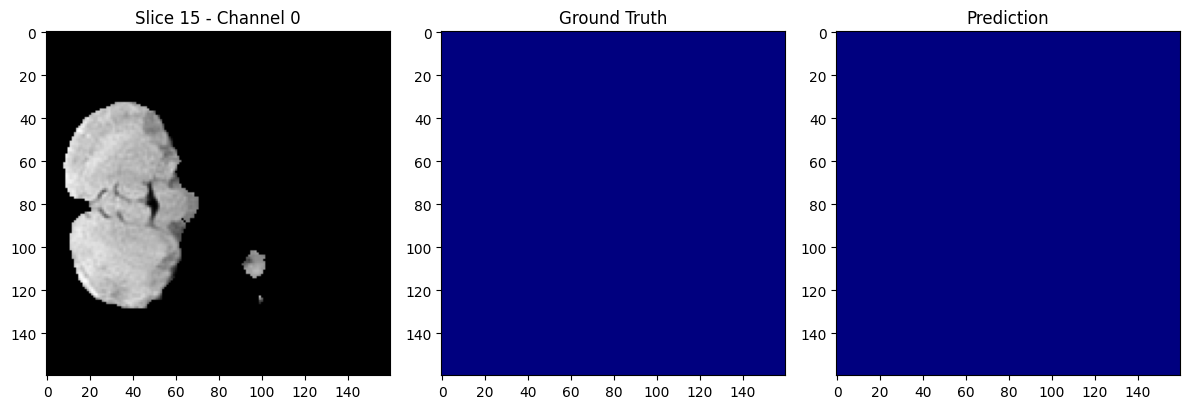

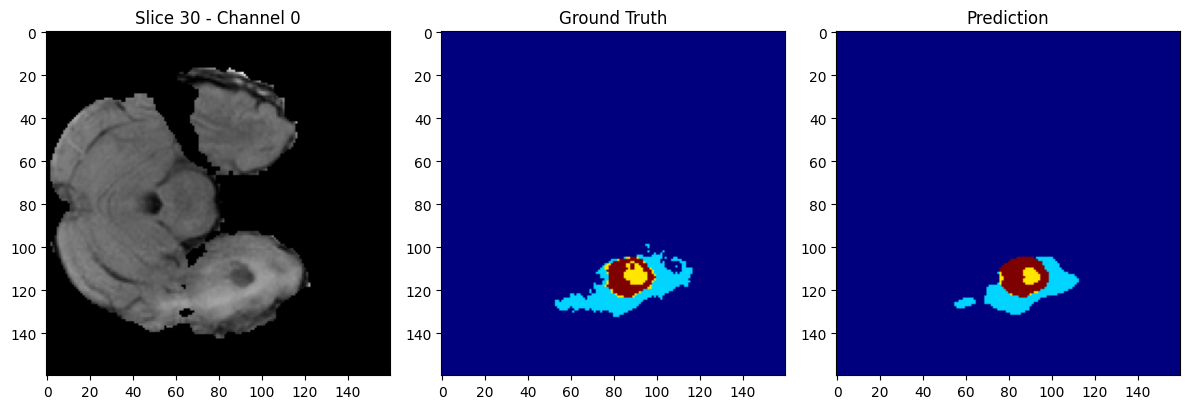

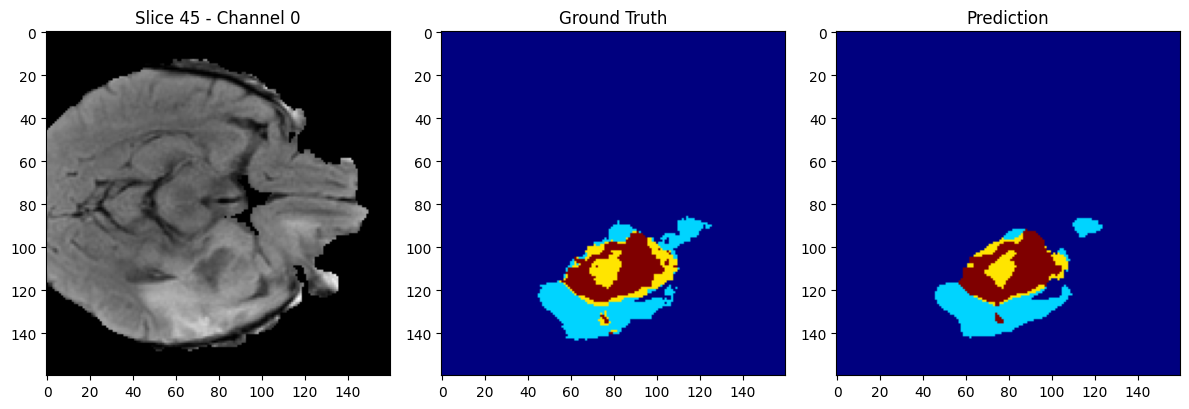

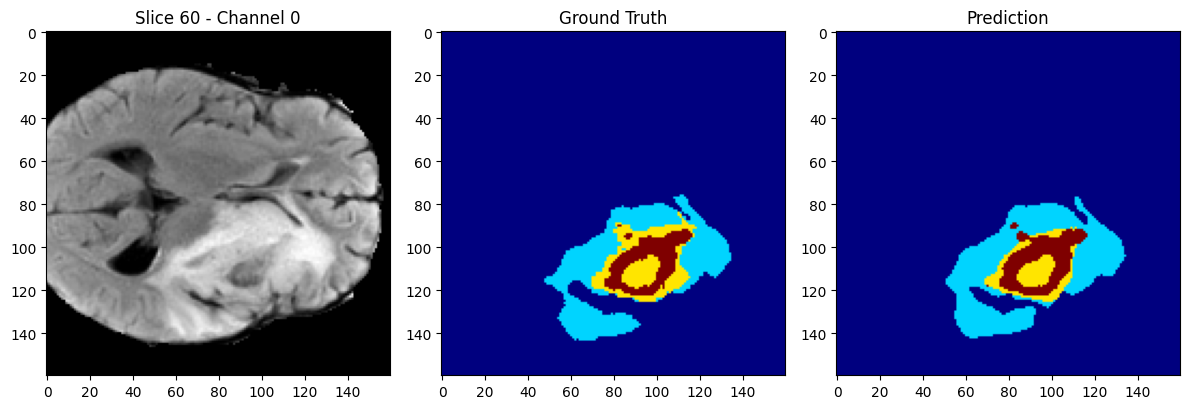

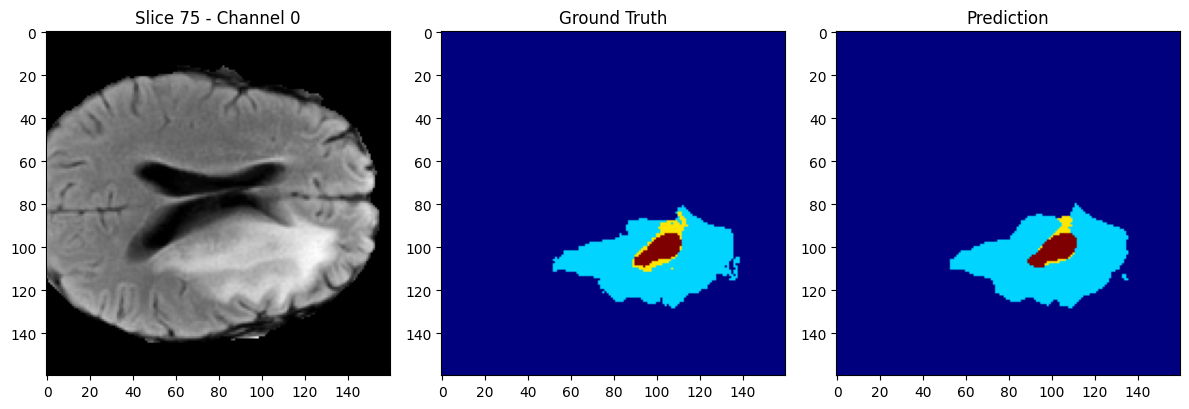

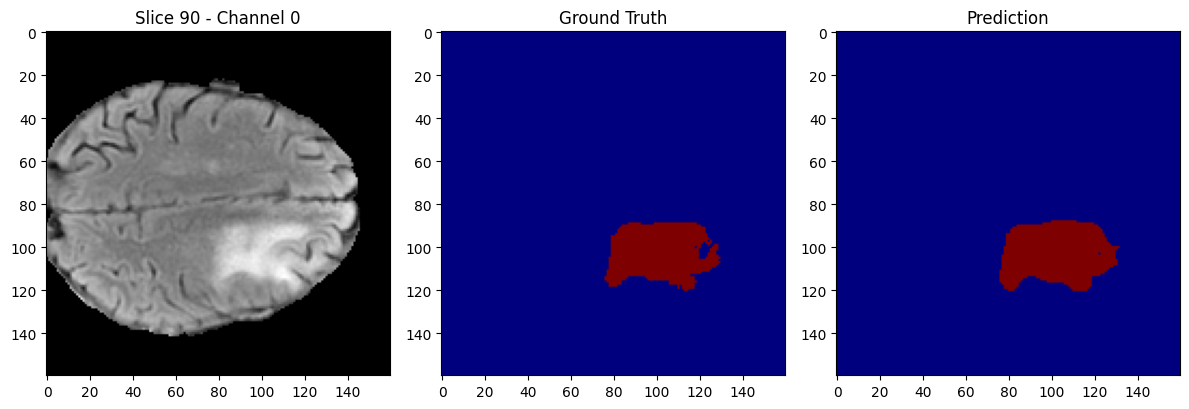

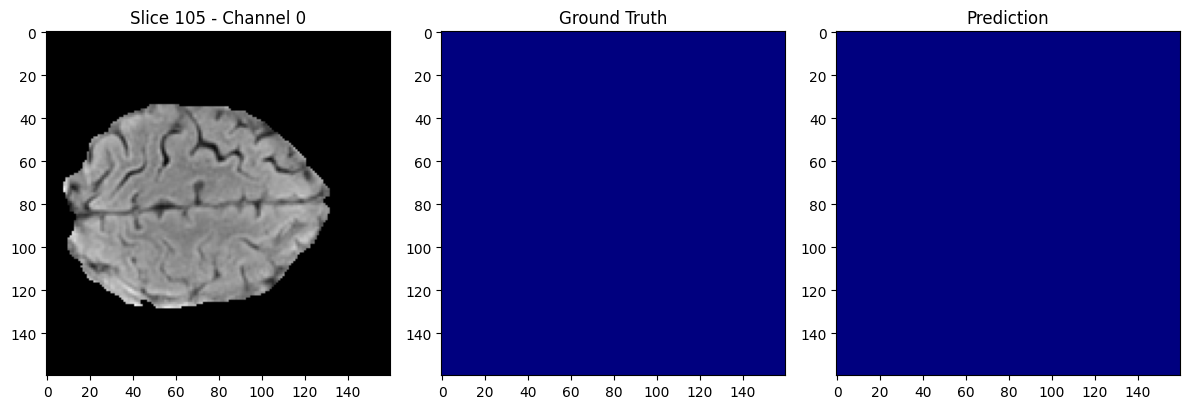

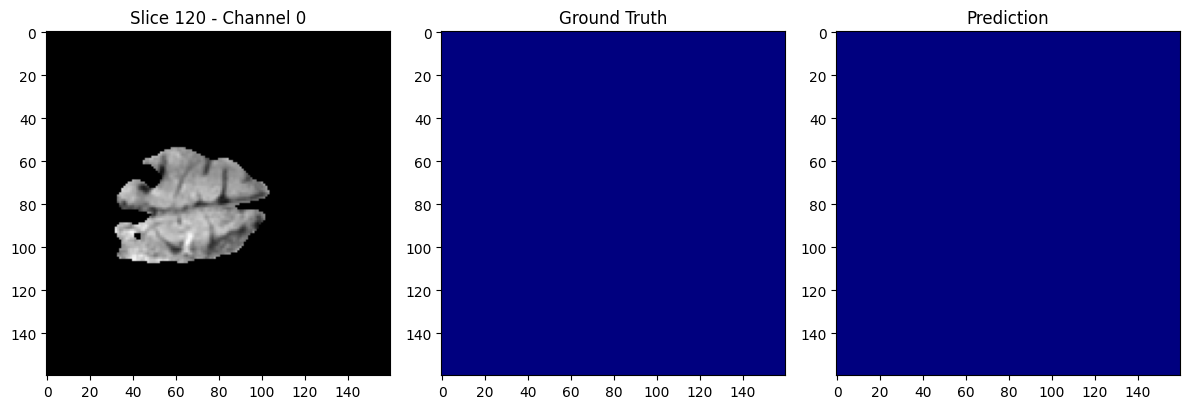

In [38]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

# load model
model = keras.models.load_model(
    '/content/drive/MyDrive/Colab Notebooks/Deep Learning Project/checkpoints/Cross Entropy & Dice loss v4/epoch_36.keras',
    custom_objects={
        'InstanceNormalization': InstanceNormalization,
        'combined_cce_dice_loss': combined_cce_dice_loss
    },
    compile=False
)

# load image and label
img_path = '/content/imageTest/BRATS_205.nii.gz'
label_path = '/content/labelTest/BRATS_205.nii.gz'

img = nib.load(img_path).get_fdata()         # shape: (H, W, D, C)
label = nib.load(label_path).get_fdata()     # shape: (H, W, D)

# check dimensions
print(f"Image shape: {img.shape}")
print(f"Label shape: {label.shape}")

# parameters
depth = img.shape[2]
H, W, total_depth, C = img.shape
pred_volume = np.zeros(label.shape, dtype=np.uint8)

# slices
for i in range(0, total_depth - depth + 1, depth):
    input_block = img[:, :, i:i+depth, :]  # (H, W, D, C)
    input_block = np.expand_dims(input_block, axis=0)  # (1, H, W, D, C)

    pred = model.predict(input_block)
    pred_labels = np.argmax(pred[0], axis=-1)  # (H, W, D)

    pred_volume[:, :, i:i+depth] = pred_labels

# plot slices
for i in range(15, total_depth, 15):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img[:, :, i, 0], cmap='gray')
    plt.title(f'Slice {i} - Channel 0')

    plt.subplot(1, 3, 2)
    plt.imshow(label[:, :, i], cmap='jet')
    plt.title('Ground Truth')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_volume[:, :, i], cmap='jet')
    plt.title('Prediction')

    plt.tight_layout()
    plt.show()